# Programación para Análisis de Datos

## ANOVA de una via

### Caso veteranos con cáncer de pulmón
### Mtra. Gisel Hernández Chávez

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from scipy.stats import f_oneway

In [9]:
import statsmodels.api as sm

In [10]:
# Para obtener múltiples salidas de una celda
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [11]:
df = pd.read_csv(r'./dataset-25346_dum_feat.csv')
df

,trt,prior,celltype,trt.1,prior.1,time,karno,diagtime,age,trt_2,celltype_large,celltype_smallcell,celltype_squamous,status_1,prior_10,celltype_large.1,celltype_smallcell.1,celltype_squamous.1,karno_bin,age_bin
0,1,0,squamous,1,0,72,60,7,69,0,0,0,1,1,0,0,0,1,"(40.0, 60.0]","(66.0, 81.0]"
1,1,10,squamous,1,10,411,70,5,64,0,0,0,1,1,1,0,0,1,"(60.0, 75.0]","(62.0, 66.0]"
2,1,0,squamous,1,0,228,60,3,38,0,0,0,1,1,0,0,0,1,"(40.0, 60.0]","(33.999, 51.0]"
3,1,10,squamous,1,10,126,60,9,63,0,0,0,1,1,1,0,0,1,"(40.0, 60.0]","(62.0, 66.0]"
4,1,10,squamous,1,10,118,70,11,65,0,0,0,1,1,1,0,0,1,"(60.0, 75.0]","(62.0, 66.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2,0,large,2,0,133,75,1,65,1,1,0,0,1,0,1,0,0,"(60.0, 75.0]","(62.0, 66.0]"
133,2,0,large,2,0,111,60,5,64,1,1,0,0,1,0,1,0,0,"(40.0, 60.0]","(62.0, 66.0]"
134,2,10,large,2,10,231,70,18,67,1,1,0,0,1,1,1,0,0,"(60.0, 75.0]","(66.0, 81.0]"
135,2,0,large,2,0,378,80,4,65,1,1,0,0,1,0,1,0,0,"(75.0, 99.0]","(62.0, 66.0]"


In [12]:
data = df.copy() # resguarda archivo cargado con todas las características

In [13]:
df.columns

Index(['trt', 'prior', 'celltype', 'trt.1', 'prior.1', 'time', 'karno',
       'diagtime', 'age', 'trt_2', 'celltype_large', 'celltype_smallcell',
       'celltype_squamous', 'status_1', 'prior_10', 'celltype_large.1',
       'celltype_smallcell.1', 'celltype_squamous.1', 'karno_bin', 'age_bin'],
      dtype='object')

In [14]:
# Eliminar las categóricas originales y dejar dummies en este dataset
df_dum = data.drop(['trt', 'prior', 'celltype' ], axis=1)
# quitar dummies en este dataset
df = data.drop(['trt_2','celltype_large', 'celltype_smallcell', 'celltype_squamous',
                'prior_10'], axis=1)

### Eliminando observaciones censuradas (no se sabe si el paciente murió)

In [15]:
df_dum = df_dum[df_dum.status_1 == 1]
df = df[df.status_1 == 1]
df.shape

(128, 15)

#### Calculando la proporción de cada grupo de tratamiento trt para el ANOVA

Para responder a la pregunta ¿Qué grupo de tratamiento (trt) tiene mayor supervivencia después 1 año? podemos hacer un análisis de varianza con las siguientes hipótesis:

    + __Ho:__ No hay diferencia entre grupos: las medias para la variable dependiente (time, por ejemplo) son iguales
    + __Ha:__ Hay diferencias entre los dos grupos
    
Para esta pregunta la variable dependiente tiempo (time) es continua.

Si la variable dependiente fuera dicotómica (status), se convierte en un problema de clasificación.
    
Es importante determinar el tamaño de muestra cuando vamos a hacer el experimento (estudio). Cuando tenemos datos ya observados, debemos determinar si los datos son suficientes, así como la potencia del estudio con ese tamaño de muestra.

### Algunos elementos teóricos sobre el ANOVA de una vía

El ANOVA unidireccional o de una vía prueba la hipótesis nula de que dos o más grupos tienen la misma media poblacional. La prueba se aplica a muestras de dos o más grupos, posiblemente con diferentes tamaños.

+ En ANOVA la variable dependiente tiene que ser continua (de intervalo o de razón).
+ Las variables independientes tienen que ser categóricas (nominales u ordinales).
+ Es una prueba paramétrica, al igual que la prueba t
+ La prueba ANOVA tiene __suposiciones importantes__ que deben cumplirse para que el valor p asociado sea válido.

    1. Las muestras son independientes.
    2. Cada muestra es de una población normalmente distribuida.
    3. Las desviaciones estándar de población de los grupos son todas iguales. Este
        propiedad se conoce como homocedasticidad.

+ Con f_oneway de scipy:
    + Si estas suposiciones no son ciertas para un conjunto dado de datos, aún puede ser posible utilizar la prueba H de Kruskal-Wallis (`scipy.stats.kruskal`) o la prueba Alexander-Govern (`scipy.stats.alexandergovern`) aunque con alguna pérdida de potencia.
    + La longitud de cada grupo debe ser de al menos uno, y debe haber al menos un grupo con longitud mayor que uno. Si estas condiciones no están satisfechos, se genera una advertencia y (``np.nan``, ``np.nan``) es regresado.
    + Si todos los valores de cada grupo son idénticos y existen al menos dos grupos con diferentes valores, la función genera una advertencia y devuelve (``np.inf``, 0).
    + Si todos los valores en todos los grupos son iguales, la función genera una advertencia y devuelve (``np.nan``, ``np.nan``).
    + El algoritmo es de Heiman [G.W. Heiman, "Understanding research methods and statistics: An integrated introduction for psychology", Houghton, Mifflin and Company, 2001.]_, pp.394-7.

Ver notebook del profe en github

https://www.pythonfordatascience.org/anova-python/

<div>
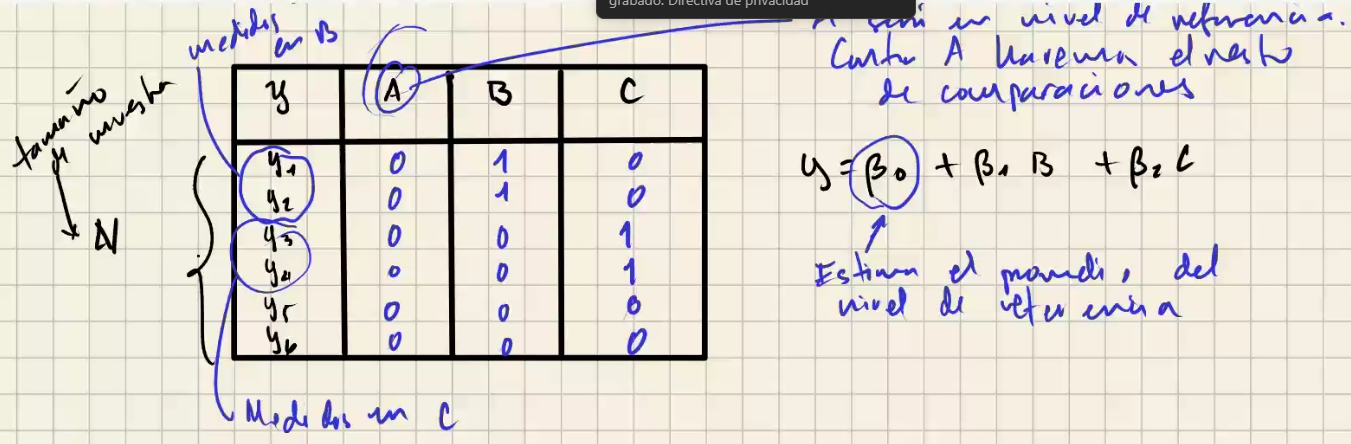
</div>


<div>
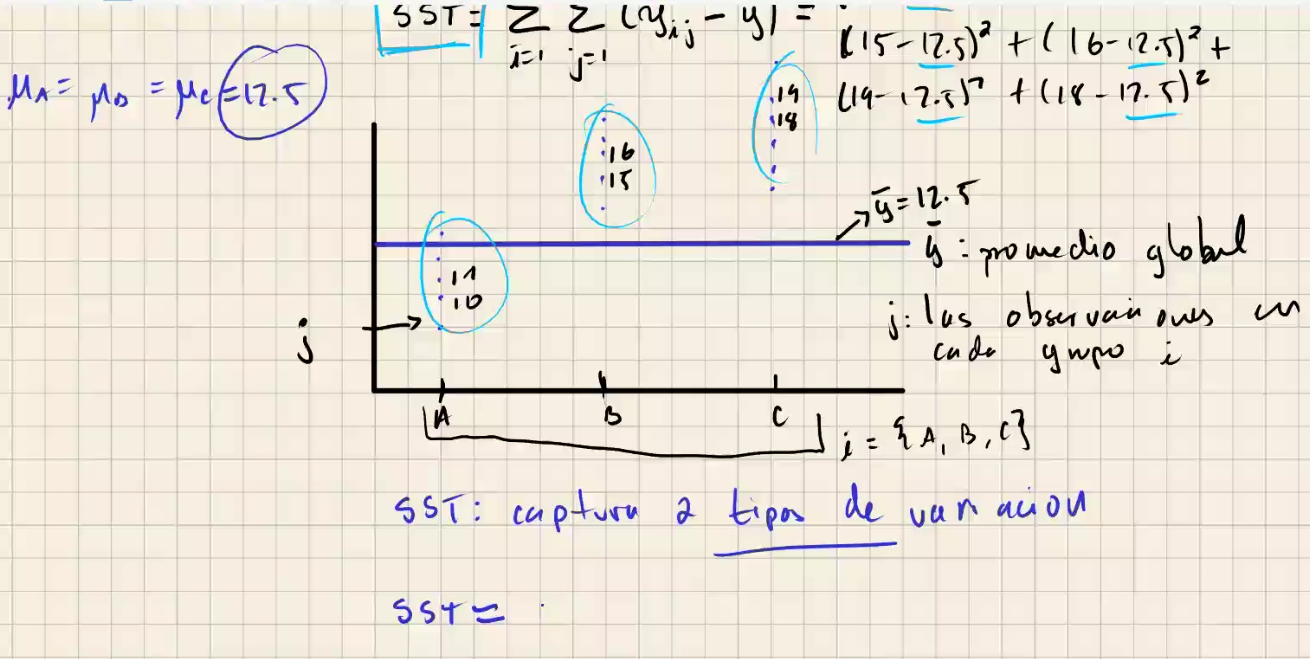
</div>


<div>
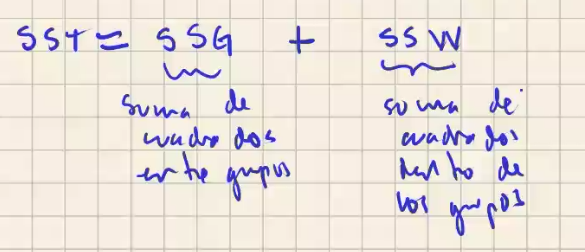
</div>


#### Tamaño de la muestra para variable time (continua)

https://clincalc.com/stats/samplesize.aspx

+ Usemos como media del tiempo 150 días y desviación estándard de 90 días para el tratamiento 1 (basados en supuestos reportes de literatura anteriorres)

<div>
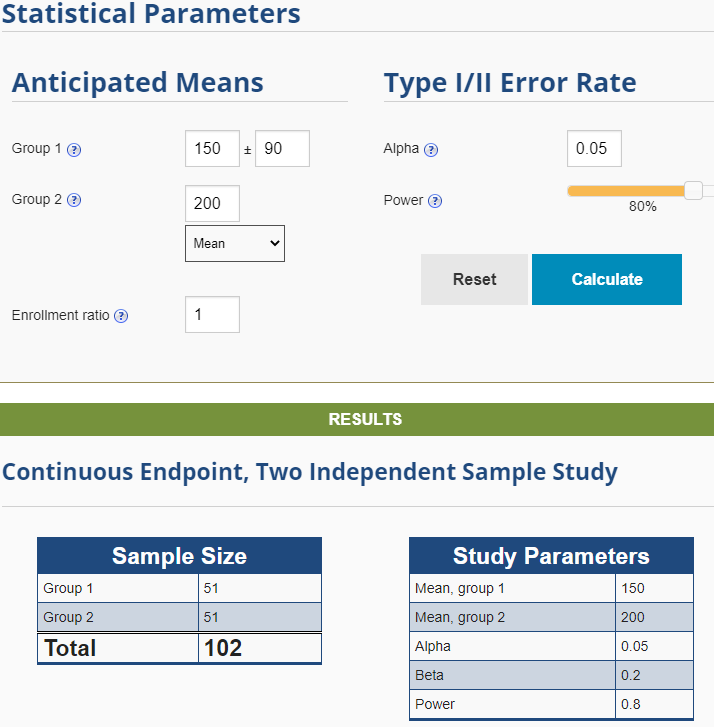
</div>


Para este estudio, según esta regla, el tamaño de la muestra es suficiente

+ Algunos autores recomiendan muestras de 100 + 50*i, donde i es la cantidad de variables

Para i =1 (una sola variable predictora) se requieren 150 observaciones


#### ANOVA de una vía para los dos tratamientos

+ Aquí la variable dependiente es time y la independiente son los tratamientos
+ Usa una prubeba F https://www.uv.es/webgid/Inferencial/41_prueba_f.html
+ La variable aleatoria F se define como el cociente de dos variables aleatorias chi-cuadrada independientes, cada una dividida entre sus respectivos grados de libertad.
+ El estadístico F (de Fisher) F = MCE / MCI contrasta las medias cuadráticas entre grupos (MCE) con las intra grupos (MCI).

In [16]:
df1 = df[df.trt ==1]
df2 = df[df.trt ==2]

In [17]:
df1.shape,df2.shape

((64, 15), (64, 15))

In [18]:
nominales = ['trt', 'prior', 'celltype']
ordinales = []
for i in nominales + ordinales:
    print(i)
    df[i].value_counts()
    print()

trt


1    64
2    64
Name: trt, dtype: int64


prior


0     91
10    37
Name: prior, dtype: int64


celltype


smallcell    45
squamous     31
adeno        26
large        26
Name: celltype, dtype: int64

### Se verifica que los tamaños de muestra son suficientes para una potencia del 80%

+ Se requerían 51 observaciones como mínimo para cada muestra de tratamientos trt y tenemos 64 (con power=0.8)
+ Note que no se puede realizar ANOVA para prior y para celltype con 4 categorias porque no hay suficientes muestras para cada grupo. En el caso de celltype se puede crear una nueva característica agrupando en solo 2 categorias (con power=0.8).

### Comprobación del supuesto de normalidad de las muestras

+ Puede emplearse comprobación visual con histograma y con QQ plot
+ Hay varias pruebas para probar hipótesis de normalidad

#### qqplot()

sm.qqplot() : Gráfico Q-Q de los cuantiles de x frente a los cuantiles/ppf de una distribución.

Es un diagrama de dispersión creado al graficar dos conjuntos de cuantiles uno contra el otro. Si ambos conjuntos de cuantiles provienen de la misma distribución, deberíamos ver los puntos formando una línea más o menos recta.

+ La función de punto de probabilidad o __ppf__ es la inversa de la __cdf (Cumulative density function)__. Específicamente, la ppf devuelve el punto exacto donde la probabilidad de todo a la izquierda es igual a un valor dado 'x' . Esto se puede considerar como la función percentil ya que la ppf nos dice el valor de un percentil dado de los datos. Si 'x' es 1- alpha (nivel de significancia; 0.95, por ejemplo)
+ cdf es a probabilidad de todos los resultados menores o iguales a un valor 'x' dado. Gráficamente, esta es el área total de todo lo que es menor o igual a 'x' (el área total a la izquierda de x)

Observe la siguiente gráfica de una distribución normal estándar con media 0 y desviación estándar 1

<div>
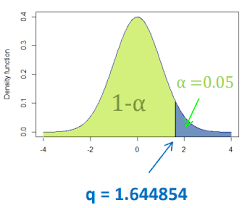
</div>


Ver https://www.statology.org/normality-test-python/


<AxesSubplot: xlabel='time', ylabel='Count'>

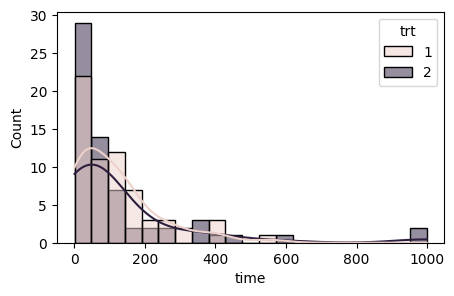

In [19]:
# Histogramas para las dos muestras
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(data=df, x="time", hue='trt',kde=True)


### Interpretación
+ No parece cumplirse el supuesto de normalidad puesto que no tienen forma de campana las distribuciones


In [20]:
import scipy.stats as stats

In [21]:
# Función de densidad acumulada para una normal estándard (los valores de x se han normalizado con un z score)
# z = 1.2
stats.norm.cdf(1.2)

0.8849303297782918

In [22]:
# Para X 
X = np.random.normal(5, 1.6, 100)
mu = X.mean()  # media real
mu

4.917848128850898

In [23]:
sigma = X.std() # sigma real
sigma

1.5978196607289146

In [24]:
# Z
Z = stats.zscore(X) # X-mu/sigma
Z

array([ 0.26519376, -0.44889545, -0.06783977,  1.22267153,  0.25257881,
       -1.49871312, -0.21797322,  0.2286878 ,  0.36463152,  0.4553609 ,
       -1.24706495, -0.23419644,  1.23394532,  0.972883  , -0.71245714,
        0.58327728, -1.14767911,  0.17354655,  0.41297387,  0.18106025,
       -0.76846902,  0.51327939,  0.9472365 , -0.79206106,  0.16605027,
       -1.06570244, -1.15895876, -0.42337714, -0.32230567,  0.18038368,
       -1.30132826, -0.98879469,  0.81045391,  2.08081471,  2.19756064,
        0.21939796,  1.13348793, -0.50141214, -0.70158645, -0.0091491 ,
       -0.2225789 , -0.21631647, -0.94430616,  0.89483916, -0.27293815,
        0.83588329,  0.19079072,  0.64354835,  1.08354572, -0.40699037,
       -0.63540875, -1.63135898,  1.92614221,  0.6935856 , -0.31327198,
        1.56129876, -0.83432029, -0.96602818, -0.90057576, -1.84711286,
       -1.40086229, -1.84599292,  1.51680284, -1.52034332,  0.28633477,
        1.41391937, -1.68959251,  1.0003481 , -1.40994545, -0.07

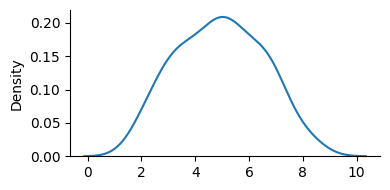

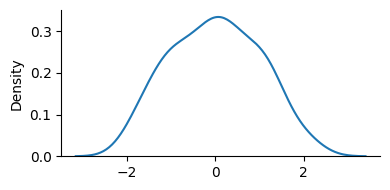

In [25]:
sns.displot(X,kind='kde',height=2, aspect=2)
sns.displot(Z,kind='kde',height=2, aspect=2)

In [26]:
# probabilidad de que x > 4
1- stats.norm.cdf(4, loc=mu,scale=sigma)

0.7171642350758309

In [27]:
# probabilidad de que 2 < x < 4
stats.norm.cdf(4, loc=mu,scale=sigma) - stats.norm.cdf(2, loc=mu,scale=sigma)

0.24892144693920987

In [28]:
# probabilidad de que x < 8
stats.norm.cdf(8, loc=mu,scale=sigma)

0.9731329273459592

In [29]:
# Función de punto de probabilidad para una normal estándard (los valores de x se han normalizado con un z score)
# es la inversa de cdf
stats.norm.ppf(0.8849303297782918)

1.2000000000000004

In [30]:
# ¿cuánto es el valor de x para el 50% de la población? Debe coincidir con mu
stats.norm.ppf(0.5,loc=mu,scale=sigma)

4.917848128850898

In [31]:
sm.qqplot?

Signature:
sm.qqplot(
    data,
    dist=<scipy.stats._continuous_distns.norm_gen object at 0x000001D5BB122460>,
    distargs=(),
    a=0,
    loc=0,
    scale=1,
    fit=False,
    line=None,
    ax=None,
    **plotkwargs,
)
Docstring:
Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.

Can take arguments specifying the parameters for dist or fit them
automatically. (See fit under Parameters.)

Parameters
----------
data : array_like
    A 1d data array.
dist : callable
    Comparison distribution. The default is
    scipy.stats.distributions.norm (a standard normal).
distargs : tuple
    A tuple of arguments passed to dist to specify it fully
    so dist.ppf may be called.
a : float
    Offset for the plotting position of an expected order statistic, for
    example. The plotting positions are given by (i - a)/(nobs - 2*a + 1)
    for i in range(0,nobs+1)
loc : float
    Location parameter for dist
scale : float
    Scale parameter for dist
fit : bool
    If f

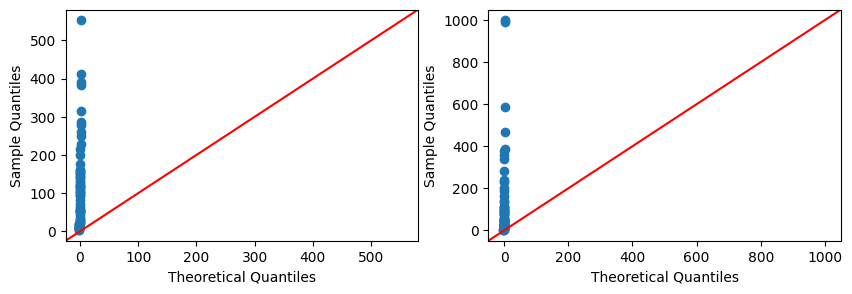

In [32]:
# qq plot para las dos muestras
#create Q-Q plot with 45-degree line added to plot
fig,ax = plt.subplots(1,2,figsize=(10,3))
a = sm.qqplot(df1.time, line='45',ax=ax[0])
b = sm.qqplot(df2.time, line='45',ax=ax[1])
plt.show()


### Interpretación

+ Se confirma que no siguen distribución normal porque los puntos no están sobre la línea roja

In [33]:
# Prueba de Shapiro-Wilk
from scipy.stats import shapiro 

#perform Shapiro-Wilk test for normality
shapiro(df1.time)


ShapiroResult(statistic=0.8371237516403198, pvalue=6.814551625211607e-07)

In [34]:
#perform Shapiro-Wilk test for normality
shapiro(df2.time)
# Dado que el valor de p es inferior a 0,05, rechazamos la hipótesis nula de la prueba de Shapiro-Wilk.
# Esto significa que tenemos suficiente evidencia para decir que los datos de la muestra no provienen de una distribución normal.

ShapiroResult(statistic=0.6061916351318359, pvalue=7.894716998191331e-12)

### Interpretación

+ Dado que el valor de p es inferior a 0,05 para ambos tratamientos, rechazamos la hipótesis nula de la prueba de Shapiro-Wilk.
+ Esto significa que tenemos suficiente evidencia para decir que __los datos de la muestra no provienen de una distribución normal.__

### Conclusiones

+ Como no cumple este supuesto, no tiene caso continuar.
+ Pueden aplicarse técnicas de Ingeniería de características (transformaciones) para que la variable se acerque a la normalidad

### Cómo manejar datos no normales

Si un conjunto de datos dado no tiene una distribución normal, a menudo podemos realizar una de las siguientes transformaciones para que tenga una distribución más normal:

1. Transformación logarítmica: transforma los valores de x a log(x).

2. Transformación de raíz cuadrada: transforma los valores de x a √x.

3. Transformación de raíz cúbica: transforma los valores de x a x1/3.

Al realizar estas transformaciones, el conjunto de datos suele tener una distribución más normal.

In [35]:
df.columns

Index(['trt', 'prior', 'celltype', 'trt.1', 'prior.1', 'time', 'karno',
       'diagtime', 'age', 'status_1', 'celltype_large.1',
       'celltype_smallcell.1', 'celltype_squamous.1', 'karno_bin', 'age_bin'],
      dtype='object')

ValueError: Could not interpret value `log_time` for parameter `x`

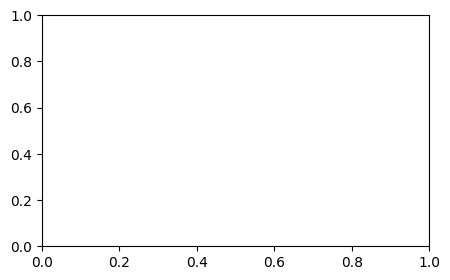

In [37]:

fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(data=df, x="log_time", hue='trt',kde=True)

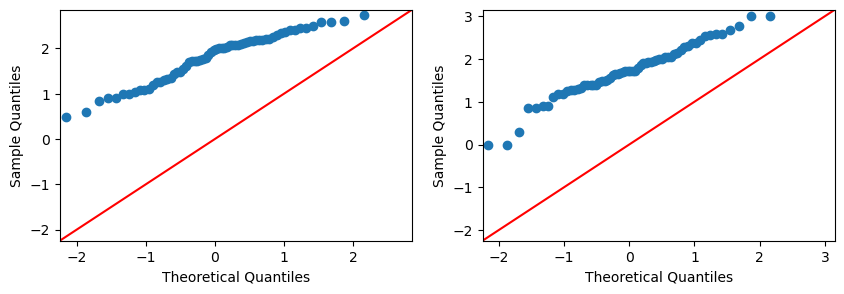

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
a = sm.qqplot(df1.log_time, line='45',ax=ax[0])
b = sm.qqplot(df2.log_time, line='45',ax=ax[1])
plt.show()

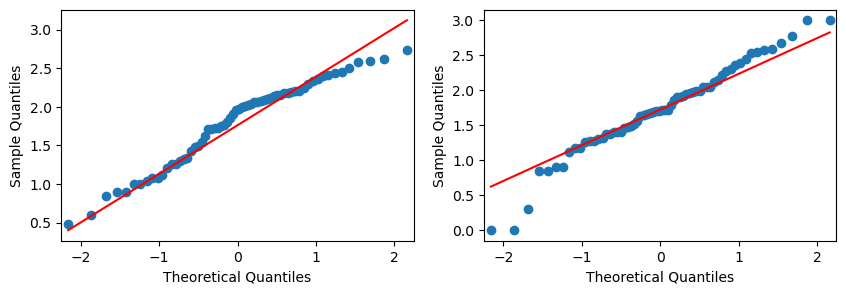

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
a = sm.qqplot(df1.log_time, line='q',ax=ax[0])
b = sm.qqplot(df2.log_time, line='q',ax=ax[1])
plt.show()

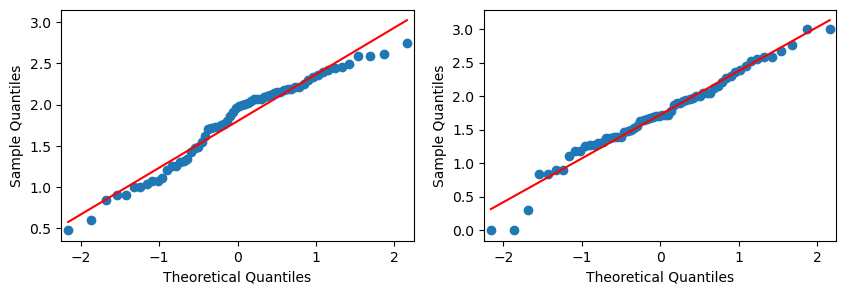

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
a = sm.qqplot(df1.log_time, line='r',ax=ax[0])
b = sm.qqplot(df2.log_time, line='r',ax=ax[1])
plt.show()

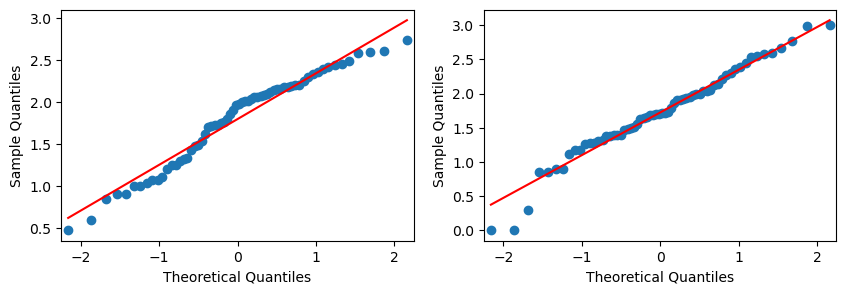

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
a = sm.qqplot(df1.log_time, line='s',ax=ax[0])
b = sm.qqplot(df2.log_time, line='s',ax=ax[1])
plt.show()

### Interpretación

+ Se acercan más a una distribución normal porque los puntos están más cercanos a la línea roja

### Prueba de Shapiro

La prueba de Shapiro-Wilk prueba la hipótesis nula de que los datos se extrajeron de una distribución normal.

In [ ]:
shapiro(df1.log_time)
# El resultado con p < 0.05 hace rechazar la hipótesis nula de que la muestra de trt=1 es normal

ShapiroResult(statistic=0.9555513858795166, pvalue=0.021655132994055748)

In [ ]:
shapiro(df2.log_time)
# El resultado con p > 0.05 NO permite rechazar la hipótesis nula de que la muestra de trt=2 es normal

ShapiroResult(statistic=0.9739131927490234, pvalue=0.19276098906993866)

In [ ]:
shapiro(df.log_time)
# El resultado con p > 0.05 no permite rechazar la hipótesis nula de que la muestra es normal

ShapiroResult(statistic=0.9812072515487671, pvalue=0.07286855578422546)

### Interpretación

+ Para el tratamiento 1 El resultado con p < 0.05 hace rechazar la hipótesis nula de que la muestra es normal
+ Para el tratamiento 2 El resultado con p > 0.05 NO hace rechazar la hipótesis nula de que la muestra es normal

### Otras transformaciones
+ Puede probarse con np.cbrt(data) para raíz cúbica


In [ ]:
df['cbr_time'] = np.cbrt(df.time)
df1['cbr_time'] = np.cbrt(df1.time)
df2['cbr_time'] = np.cbrt(df2.time)

C:\Users\ghernand\AppData\Local\Temp\ipykernel_10300\233579189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['cbr_time'] = np.cbrt(df1.time)
C:\Users\ghernand\AppData\Local\Temp\ipykernel_10300\233579189.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['cbr_time'] = np.cbrt(df2.time)


<Axes: xlabel='cbr_time', ylabel='Count'>

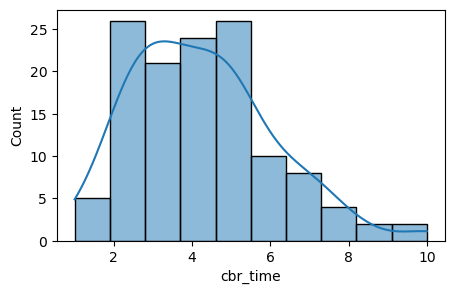

In [ ]:
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(data=df, x="cbr_time",kde=True)

<Axes: xlabel='cbr_time', ylabel='Count'>

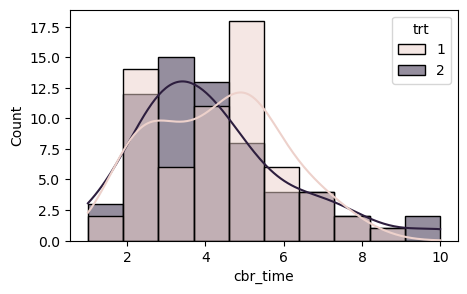

In [ ]:
fig,ax = plt.subplots(figsize=(5,3))
sns.histplot(data=df, x="cbr_time", hue='trt',kde=True)

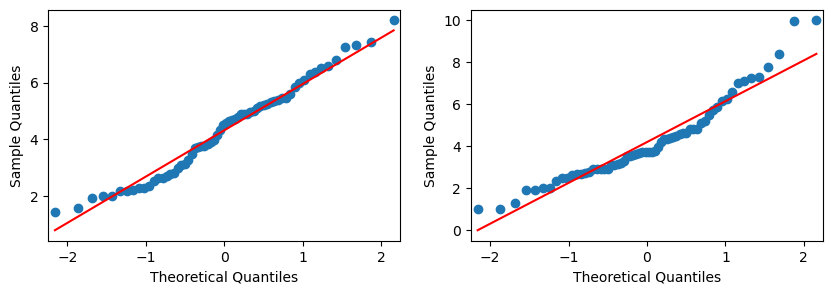

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,3))
a = sm.qqplot(df1.cbr_time, line='s',ax=ax[0])
b = sm.qqplot(df2.cbr_time, line='s',ax=ax[1])
plt.show()

In [ ]:
shapiro(df1.cbr_time)

ShapiroResult(statistic=0.9722755551338196, pvalue=0.15877842903137207)

In [ ]:
shapiro(df2.cbr_time)

ShapiroResult(statistic=0.9298248291015625, pvalue=0.0013118747156113386)

In [ ]:
shapiro(df.cbr_time)
# El resultado con p > 0.05 no permite rechazar la hipótesis nula de que la muestra es normal

ShapiroResult(statistic=0.9656596779823303, pvalue=0.002476647961884737)

### Interpretación

+ Para el tratamiento 1 El resultado con p > 0.05 NO hace rechazar la hipótesis nula de que la muestra es normal
+ Para el tratamiento 2 El resultado con p < hace rechazar la hipótesis nula de que la muestra es normal

### Comprobación del supuesto de homocedasticidad (igual varianza) para variable transformada time con logaritmo y raíz cúbica

+ con log_time y cbr_time


Las pruebas que puede ejecutar para verificar que sus datos cumplan con esta suposición incluyen:

1. Prueba de Bartlett(Ho: todas las muestras de entrada provienen de poblaciones con iguales varianzas; scipy.stats.bartlett)
2. Prueba M de Box
3. Prueba de Brown-Forsythe
4. Prueba Fmax de Hartley
5. __Prueba de Levene__. Prueba la hipótesis nula __H0__de que todas las muestras de entrada provienen de poblaciones con varianzas iguales. Es una alternativa a la prueba de Bartlett en el caso de que existan desviaciones significativas de la normalidad.
        
        scipy.stats.levene(*samples, center='median', proportiontocut=0.05)
        
        scipy.stats.levene() returns a tuple where the first element is W , the test's statistic, and the second element is the p-value for the test.


In [ ]:
from scipy.stats import levene, bartlett

In [ ]:
levene?

In [ ]:
bartlett(df1.log_time,df2.log_time)  # Bartlett con log_time

BartlettResult(statistic=1.1787463164423715, pvalue=0.2776113684404965)

In [ ]:
bartlett(df1.cbr_time,df2.cbr_time)  # Bartlett con cbr_time

BartlettResult(statistic=1.8964260250077642, pvalue=0.16847890667983578)

In [ ]:
levene(df1.log_time,df2.log_time) # Levene con log_time

LeveneResult(statistic=0.1836331760658417, pvalue=0.6690010402704698)

In [ ]:
levene(df1.cbr_time,df2.cbr_time)  # Levene con cbr_time

LeveneResult(statistic=0.13990379038661063, pvalue=0.7090053515964025)

### Interpretación

+ Las pruebas de Bartlett y de Levene usando log_time arrojan p > 0.05 en todos los casos: __No se rechaza H0 y se prueba homocedasticidad para las muestras de los dos tratamientos, tanto para la variable log_time como para cbr_time__

## Ejecución de ANOVA con variable dependiente cbr_time para los grupos de trt

In [ ]:
#f_oneway?

In [ ]:
f_oneway(df1.cbr_time, df2.cbr_time)

F_onewayResult(statistic=0.1672511061593571, pvalue=0.6832607730919915)

#### Interpretación

+ El estadístico F y el valor p resultan ser iguales a 0.1239 y 0.7253 respectivamente. Dado que el valor p es superior a 0.05, aceptaríamos la hipótesis nula. 
+ Esto implica que no tenemos pruebas suficientes para rechazar que el tiempo de supervivencia es el mismo para los dos tipos de tratamiento.
+ __Los tratamientos no influyen significativamente en el tiempo de vida de los pacientes__
+ Hay que explorar otras variables que influyan

#### Calculando la frecuencia y proporción de cada grupo de tipo de célula para el ANOVA

Sabiendo que el tamaño de la muestra no es suficiente para una potencia del 80%, sino que es algo inferior al 60%:

Si agregamos la pregunta de investigación: ¿Qué grupo de células tiene menos supervivencia después de 999 días? podemos hacer un análisis de varianza con las siguientes hipótesis:

    + __Ho:__ No hay diferencia entre grupos: las medias para la variable dependiente (time, por ejemplo) son iguales
    + __Ha:__ Hay al menos un grupo diferente (al menos una media diferente)

#### ANOVA de una vía para los cuatro tipos de células

+ Primero lo hacemos por pares: son 6 comparaciones porque hay 4 categorías: 3+2+1

In [ ]:
df.celltype.value_counts()

smallcell    45
squamous     31
adeno        26
large        26
Name: celltype, dtype: int64

In [ ]:
df3 = df[df.celltype =='squamous']
df4 = df[df.celltype == 'large']

In [ ]:
# entre 'squamous' y 'large'
f_oneway(df3.cbr_time, df4.cbr_time)

F_onewayResult(statistic=0.0476714323914366, pvalue=0.8279739767076253)

## 1. Interpretación squamus vs large

+ El estadístico F y el valor p resultan ser iguales a 0.4257 y 0.82 respectivamente. Dado que el valor p es superior a 0.05, aceptaríamos la hipótesis nula. 
+ Esto implica que no tenemos pruebas suficientes para rechazar que __el tiempo de supervivencia es el mismo para los  pacientes con tipos de células 'squamous' y 'large'__.(con potencia cercana a 0.6)

#### Interpretación si obtuviera un F infinito

https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/anova/how-to/one-way-anova/interpret-the-results/key-results/

"Has intentado estimar 15 términos con solo 15 puntos de datos; tenga en cuenta que le quedan 0 DOF para el término de error. Por lo tanto, el denominador en el estadístico F es 0-->inf para la estimación.
El problema está en al menos el análisis de tratar de estimar más efectos de los que tiene datos para hacer; el problema podría ser que simplemente especificó mal los términos en el modelo que no estaban destinados a ser estimados o podría ser aún más fundamental que los puntos de diseño sean tales que no pueda estimar efectivamente mucho de nada; no podemos decir, no tenemos el diseño disponible.
El procedimiento normal es preparar una hipótesis nula para probar, incluidos qué factores e interacciones, y luego diseñar, ejecutar y analizar adecuadamente para probar esa hipótesis nula. Sin embargo, con demasiada frecuencia, las personas simplemente toman un montón de datos y luego intentan forzarlos en el modelo; no tenemos forma de saber qué tuvo lugar aquí (o algo intermedio)." https://www.mathworks.com/matlabcentral/answers/297560-f-vales-come-out-as-infinity-using-the-anovan-function

It's because the Error estimate is zero, probably because you are using the response variable as a predictor of itself.https://communities.sas.com/t5/Statistical-Procedures/f-value-is-quot-Infty-quot/td-p/721600

In [ ]:
df5 = df[df.celltype =='smallcell']
df6 = df[df.celltype == 'adeno']

In [ ]:
# entre 'squamous' y 'smallcell'
f_oneway(df3.cbr_time, df5.cbr_time)

F_onewayResult(statistic=10.16569941721853, pvalue=0.002097718146951558)

In [ ]:
df3.cbr_time.mean(), df5.cbr_time.mean()

(4.989011162399519, 3.5973258328327744)

#### 2. Interpretación squamus vs smallcell
+ El estadístico F y el valor p resultan ser iguales a 10.16 y 0.002 respectivamente. Dado que el valor p es inferior a 0.05, rechazamos la hipótesis nula. 
+ Esto implica que tenemos pruebas suficientes para rechazar que el tiempo de supervivencia es el mismo para 'squamous' y 'smallcell' (con power alrededor de 0.6)
+ __El tiempo de supervivencia no es el mismo: los pacientes con squamous sobreviven más tiempo que los pacientes con smallcell__

In [ ]:
# entre 'squamous' y 'adeno'
f_oneway(df3.cbr_time, df6.cbr_time)

F_onewayResult(statistic=6.665825323881862, pvalue=0.01252193286873994)

In [ ]:
df3.cbr_time.mean(), df6.cbr_time.mean()

(4.989011162399519, 3.6509935981960053)

#### 3. Interpretación squamus vs ademo
+ El estadístico F y el valor p resultan ser iguales a 6,66 y 0.012 respectivamente. Dado que el valor p es inferior a 0.05, rechazamos la hipótesis nula. 
+ Esto implica que tenemos pruebas suficientes para rechazar que el tiempo de supervivencia es el mismo para 'squamous' y 'adeno' (con power alrededor de 0.6)
+ __El tiempo de supervivencia no es el mismo: los pacientes con squamous sobreviven más tiempo que los pacientes con adeno__

In [ ]:
# entre 'large' y 'smallcell'
f_oneway(df4.cbr_time, df5.cbr_time)

F_onewayResult(statistic=18.415160050853444, pvalue=5.677570335032944e-05)

In [ ]:
df4.cbr_time.mean(), df5.cbr_time.mean()

(5.107519528784445, 3.5973258328327744)

#### 4. Interpretación large vs smallcell
+ El estadístico F y el valor p resultan ser iguales a 18.41 y 0.00005 respectivamente. Dado que el valor p es inferior a 0.05, rechazamos la hipótesis nula. 
+ Esto implica que tenemos pruebas suficientes para rechazar que el tiempo de supervivencia es el mismo para 'large' y 'smallcell' (con power alrededor de 0.6)
+ __El tiempo de supervivencia no es el mismo: los pacientes con large sobreviven más tiempo que los pacientes con smallcell__

In [ ]:
# entre 'large' y 'adeno'
f_oneway(df4.cbr_time, df6.cbr_time)

F_onewayResult(statistic=15.167548464527595, pvalue=0.00029246398173552205)

In [ ]:
df4.cbr_time.mean(), df6.cbr_time.mean()

(5.107519528784445, 3.6509935981960053)

#### 5. Interpretación large vs adeno
+ El estadístico F y el valor p resultan ser iguales a 15.16 y 0.00029 respectivamente. Dado que el valor p es inferior a 0,05, rechazamos la hipótesis nula. 
+ Esto implica que tenemos pruebas suficientes para rechazar que el tiempo de supervivencia es el mismo para 'large' y 'adeno' (con power alrededor de 0.6)
+ __El tiempo de supervivencia no es el mismo: los pacientes con large sobreviven más tiempo que los pacientes con adeno__

In [ ]:
# entre 'smallcell' y 'adeno'
f_oneway(df5.cbr_time, df6.cbr_time)

F_onewayResult(statistic=0.027160188022289516, pvalue=0.8695805228093529)

In [ ]:
df5.cbr_time.mean(), df6.cbr_time.mean()

(3.5973258328327744, 3.6509935981960053)

#### 6. Interpretación smallcell vs adeno
+ El estadístico F y el valor p resultan ser iguales a 0.027 y 0.8695 respectivamente. Dado que el valor p es superior a 0.05, NO rechazamos la hipótesis nula. 
+ Esto implica que NO tenemos pruebas suficientes para rechazar que el tiempo medio de supervivencia es el mismo para 'smallcell' y 'adeno' (con power alrededor de 0.6)
+ __El tiempo de supervivencia promedio es el mismo para los pacientes con smallcell y adeno__

#### ANOVA de una via para todos los grupos

In [ ]:
# entre todos los grupos
f_oneway(df3.cbr_time, df4.cbr_time,df5.cbr_time, df6.cbr_time)

F_onewayResult(statistic=7.629245488563778, pvalue=0.00010097594960440589)

#### Interpretación todos contra todos

+ El estadístico F y el valor p resultan ser iguales a 7.29 y 0.0001 respectivamente. Dado que el valor p es inferior a 0,05, rechazamos la hipótesis nula. 
+ Esto implica que tenemos pruebas suficientes para rechazar que el tiempo de supervivencia es el mismo para los pacientes de todos los grupos: al menos un grupo es diferente (con power alrededor de 0.6)

### ANOVA usando regresión 

+ Con variable dependiente cbr_time 
+ Con variable independientetrt
basado en https://www.reneshbedre.com/blog/anova.html

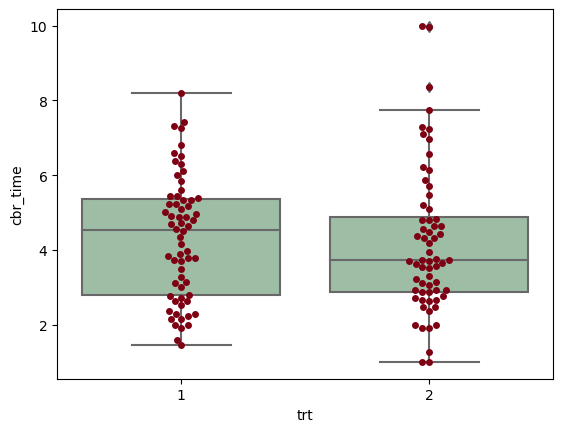

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='trt', y='cbr_time', data=df, color='#99c2a2')
ax = sns.swarmplot(x="trt", y="cbr_time", data=df, color='#7d0013')
plt.show()

In [ ]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('cbr_time ~ C(trt)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(trt),0.549136,1.0,0.167251,0.683261
Residual,413.696328,126.0,NaN,NaN


### Interpretación

+ Se obtienen el mismo resultado que con f-oneway() de scipy
+ Dado que el valor p es superior a 0.05, aceptamos la hipótesis nula, pues no tenemos pruebas suficientes para rechazar que el tiempo de supervivencia es el mismo para los dos tipos de tratamiento, con una significancia del 95 %.

### ANOVA usando regresión con variable dependiente time  e independiente los grupos de células
basado en https://www.reneshbedre.com/blog/anova.html

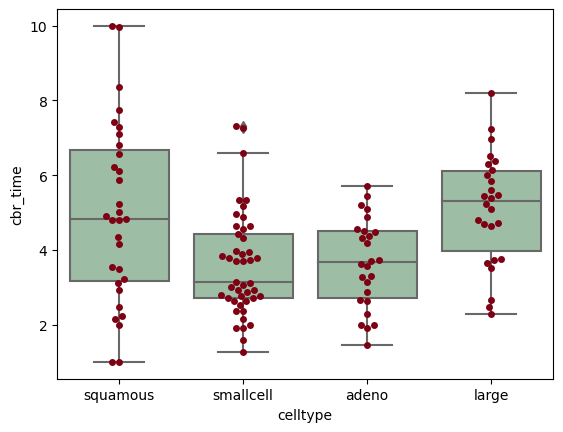

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x='celltype', y='cbr_time', data=df, color='#99c2a2')
ax = sns.swarmplot(x="celltype", y="cbr_time", data=df, color='#7d0013')
plt.show()

In [ ]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('cbr_time ~ C(celltype)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)

,sum_sq,df,F,PR(>F)
C(celltype),64.546852,3.0,7.629245,0.000101
Residual,349.698612,124.0,NaN,NaN


### Interpretación

+ El estadístico F y el valor p resultan ser iguales a 7.62 y 0.0001 respectivamente, siendo los mismos valores obtenidos con f_oneway().
+ Dado que el valor p es inferior a 0.05, rechazamos la hipótesis nula: tenemos pruebas suficientes para rechazar que el tiempo de supervivencia es el mismo para todos los grupos de células: al menos un grupo es diferente